In [ ]:
import pandas as pd
import numpy as np
from plotnine import * 
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas_datareader as pdr
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.api import ExponentialSmoothing
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
pd.set_option('display.max_rows',None)
pd.set_option('display.max_columns',None)
pd.options.mode.chained_assignment = None

Case #1

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/robertasgabrys/Forecasting/main/MidtermCase1Data.csv", skiprows=0)
df

In [ ]:
week1 = df['Week']
week2 = df['Week.1']
week3 = df['Week.2']
week4 = df['Week.3']
week = pd.concat([week1,week2,week3,week4],axis=0)
week

In [ ]:
sales1 = df['Sales']
sales2 = df['Sales.1']
sales3 = df['Sales.2']
sales4 = df['Sales.3']
sales = pd.concat([sales1,sales2,sales3,sales4],axis=0)
sales

In [ ]:
df = pd.concat([week,sales],axis=1,)
df.reset_index(inplace=True,drop=True)
df.columns = ['Week','Sales']
df

In [ ]:
df['Competition'] = 0
df.loc[87:,'Competition'] = 1
df

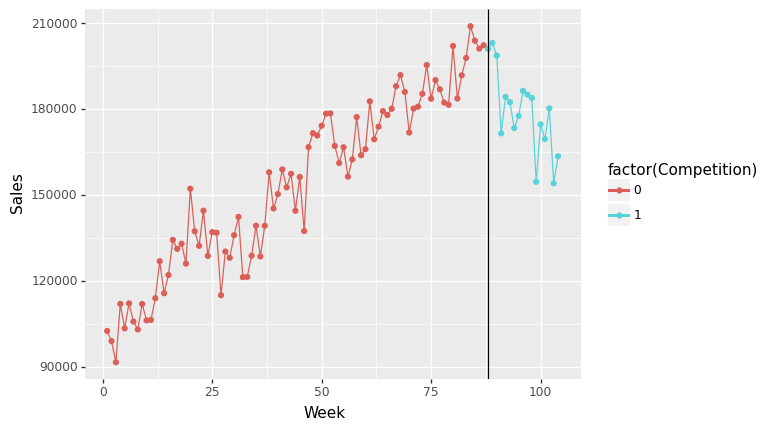

<ggplot: (8789875520977)>

In [ ]:
# DATA VIZ
(
    ggplot(df,aes('Week', 'Sales', color='factor(Competition)')) + geom_point() + geom_line() + geom_vline(xintercept = df.loc[87,'Week'], color='black')
    )

Our company's sweet potato chip sales were on a strong uptrend until the introduction of a competing product - upon which the sales began an even stronger downtrend

In [ ]:
df['SalesBefore'] = df['Sales']
df.loc[df['Competition']==1,'SalesBefore'] = np.nan
df

In [ ]:
df['Ramp'] = 0

In [ ]:
df.iloc[87:,].shape

(17, 5)

In [ ]:
df.loc[87:,'Ramp'] = list(range(18))[1:]
df

In [ ]:
# M1 = Trend + Seasonal -> SalesBefore = b0 +b1*Trend + b2...b3 * Seasonal dummies(column Quarter) ->
# In Python 'SalesBefore ~ Trend + C(Quarter)'  where C stands for categorical and Python will use dummies for column Quarter 
M1 = smf.ols('SalesBefore ~ Week + Ramp',data = df).fit()
# old = ordinary least squares = linear regression model
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.910
Method:                 Least Squares   F-statistic:                     873.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.71e-46
Time:                        18:50:23   Log-Likelihood:                -915.89
No. Observations:                  87   AIC:                             1836.
Df Residuals:                      85   BIC:                             1841.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.026e+05   1976.383     51.905      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
df['M1'] = M1.fittedvalues

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 17 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 17 rows containing missing values.


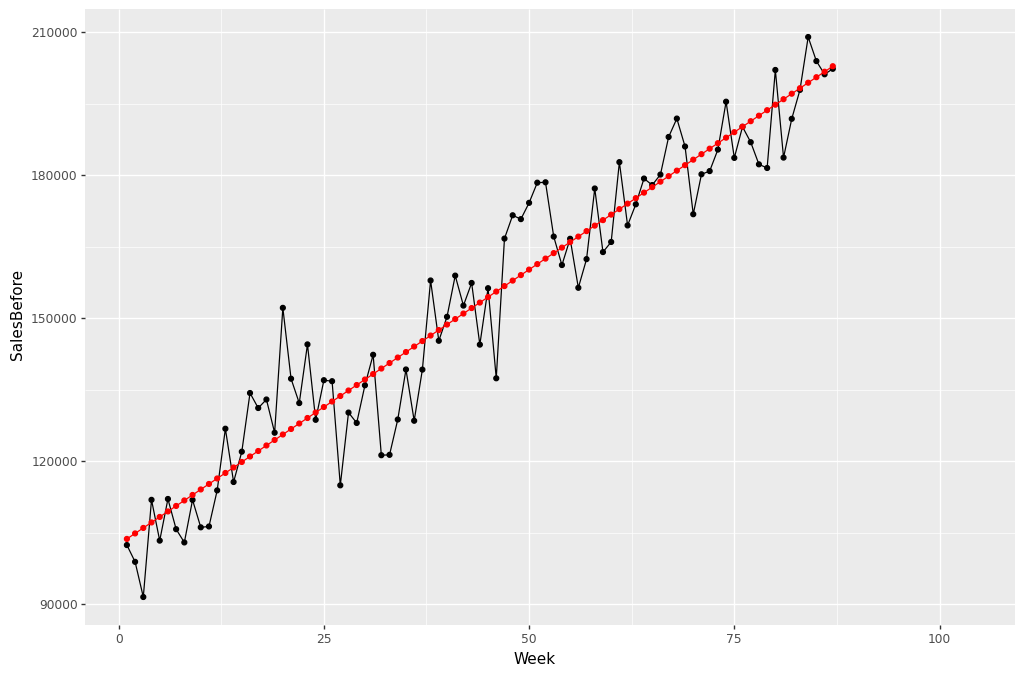

<ggplot: (8789872794101)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df,aes('Week','SalesBefore')) + geom_point() + geom_line() +
 geom_point(aes('Week','M1'), color='red') + geom_line(aes('Week','M1'),color='red') + theme(figure_size = (12,8))
)

In [ ]:
df['M1resid'] = M1.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 17 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 17 rows containing missing values.


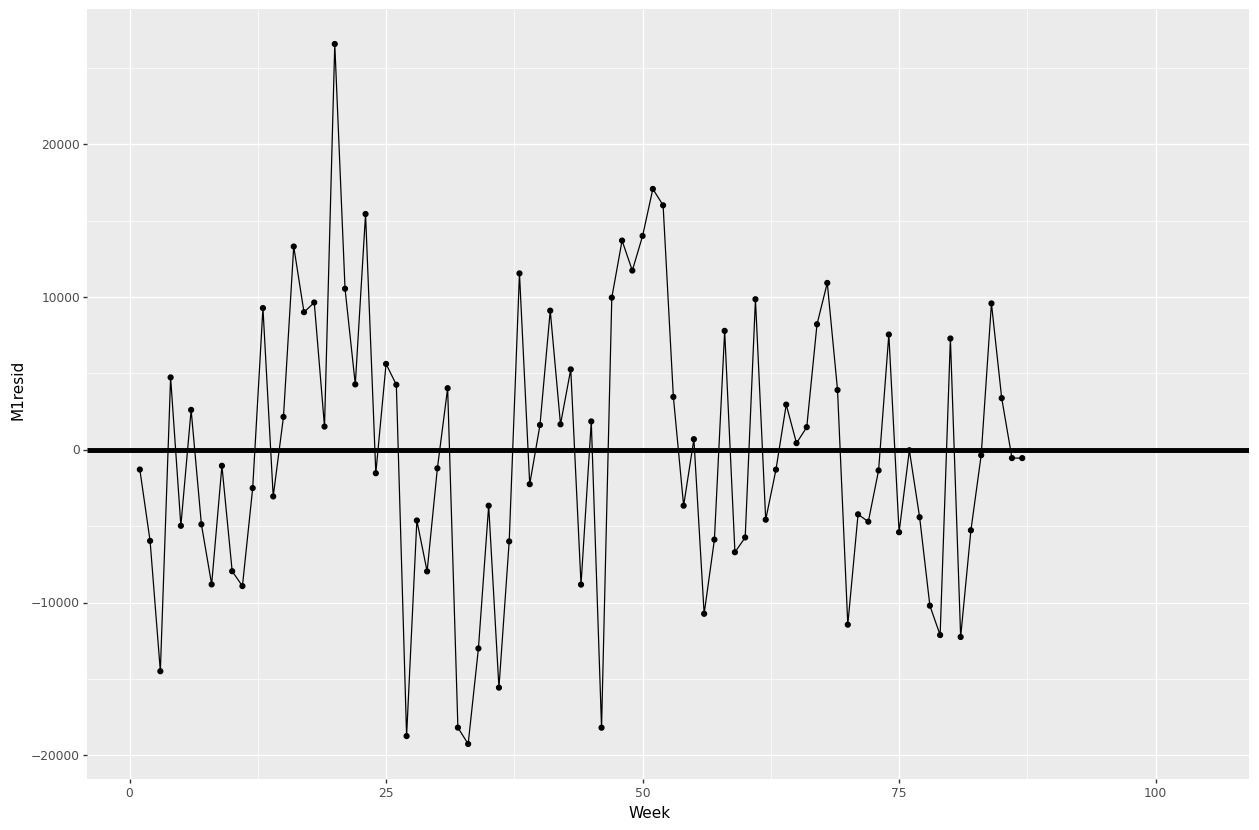

<ggplot: (8789872716781)>

In [ ]:
(
    ggplot(df,aes('Week','M1resid')) + geom_point() + geom_line() + theme(figure_size = (15,10)) + geom_hline(yintercept=0, size=2)
)

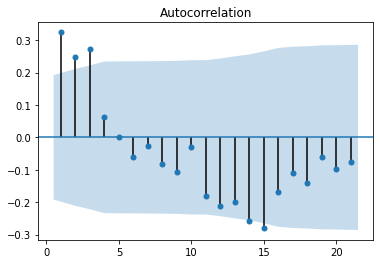

In [ ]:
plot_acf(df['M1resid'],missing='drop',zero=False);

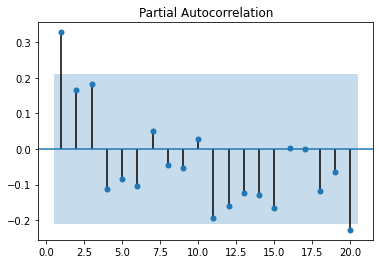

In [ ]:
plot_pacf(df.loc[df['M1resid'].notna(),'M1resid'],zero=False);

In [ ]:
df['SalesBeforeLag1'] = df['SalesBefore'].shift(1)

In [ ]:
M2 = smf.ols('SalesBefore ~ Week + Ramp + SalesBeforeLag1',data = df).fit()
# old = ordinary least squares = linear regression model
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.916
Method:                 Least Squares   F-statistic:                     464.8
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           8.28e-46
Time:                        18:50:26   Log-Likelihood:                -901.07
No. Observations:                  86   AIC:                             1808.
Df Residuals:                      83   BIC:                             1815.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        6.974e+04   1.07e+04     

/usr/local/lib/python3.7/dist-packages/statsmodels/regression/linear_model.py:1860: RuntimeWarning: divide by zero encountered in double_scalars


In [ ]:
df['M2'] = M2.fittedvalues
df['M2resid'] = M2.resid

/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 17 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 17 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/layer.py:401: PlotnineWarning: geom_point : Removed 18 rows containing missing values.
/usr/local/lib/python3.7/dist-packages/plotnine/geoms/geom_path.py:75: PlotnineWarning: geom_path: Removed 18 rows containing missing values.


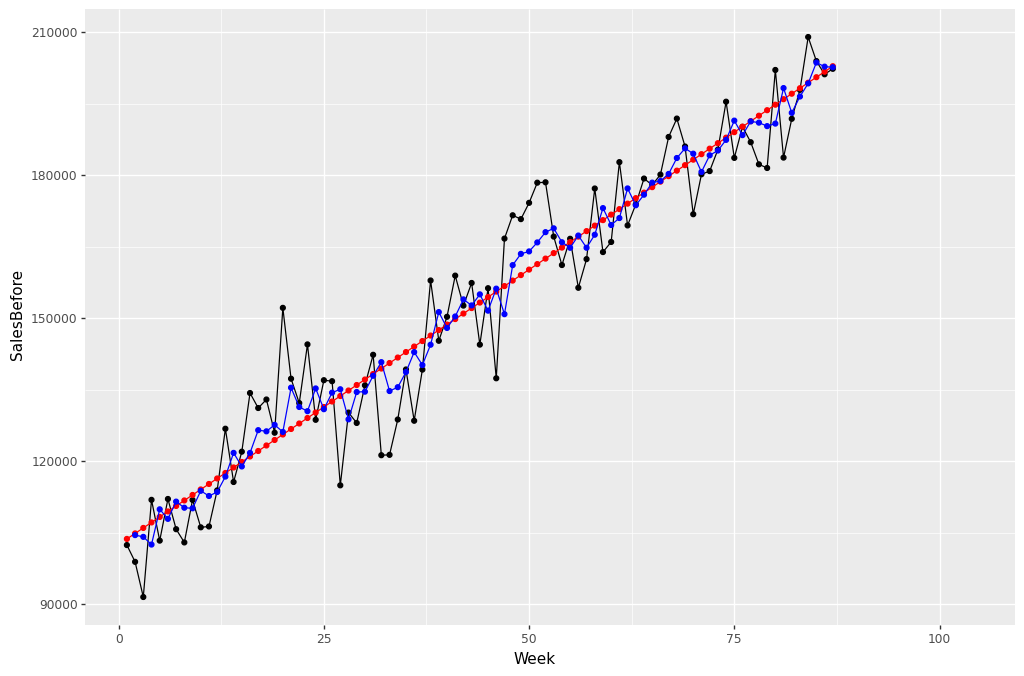

<ggplot: (8789871096977)>

In [ ]:
# Plot data and overlay fitted values
(
    ggplot(df,aes('Week','SalesBefore')) + geom_point() + geom_line() +
 geom_point(aes('Week','M1'), color='red') + geom_line(aes('Week','M1'),color='red') +
 geom_point(aes('Week','M2'), color='blue') + geom_line(aes('Week','M2'),color='blue') + theme(figure_size = (12,8))
)

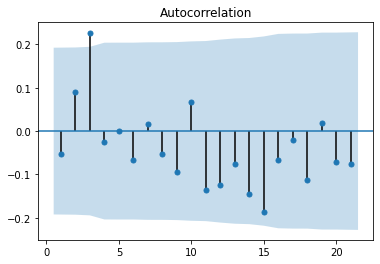

In [ ]:
plot_acf(df['M2resid'],missing='drop',zero=False);

Since less than 5% of observations are statistically significant, we can deem M2 an appropriate model of the data before the competition was introduced

In [ ]:
df.iloc[[87]]

,Week,Sales,Competition,SalesBefore,Ramp,M1,M1resid,SalesBeforeLag1,M2,M2resid
87,88,201100,1,NaN,1,NaN,NaN,202370.0,NaN,NaN


In [ ]:
df.loc[87,'SalesBefore'] = M2.predict(df.iloc[[87]]).iloc[0]
df.loc[87,'M2'] = M2.predict(df.iloc[[87]]).iloc[0]
df

In [ ]:
df.loc[88,'SalesBeforeLag1'] = df.loc[88-1,'SalesBefore']
df.loc[88,'SalesBefore'] = M2.predict(df.iloc[[88]]).iloc[0]
df.loc[88,'M2'] = M2.predict(df.iloc[[88]]).iloc[0]

In [ ]:
h = df['SalesBefore'].isna().sum()
for i in list(range(len(df) - h, len(df))):
    df.loc[i,'SalesBeforeLag1'] = df.loc[i-1,'SalesBefore']
    df.loc[i,'SalesBefore'] = M2.predict(df.iloc[[i]]).iloc[0]
    df.loc[i,'M2'] = M2.predict(df.iloc[[i]]).iloc[0]

In [ ]:
a = df.loc[87:,'Sales'].sum()
b = df.loc[87:,'SalesBefore'].sum()
c = (a-b)/b
c = c*100
c

-15.988230280305308

The introduction of the new product into market generated a -15.99% decrease in total sales in the weeks to follow.

Case #2

In [ ]:
url = 'https://www.census.gov/econ/currentdata/dbsearch?program=MARTS&startYear=1992&endYear=2022&categories%5B%5D=443&dataType=SM&geoLevel=US&notAdjusted=1&submit=GET+DATA&releaseScheduleId='
ScrapedPage = pd.read_html(url)
df = ScrapedPage[0]
df = df.set_index(['Year']).stack().reset_index()
df.columns = ['Year', 'Month', 'Sales']
df

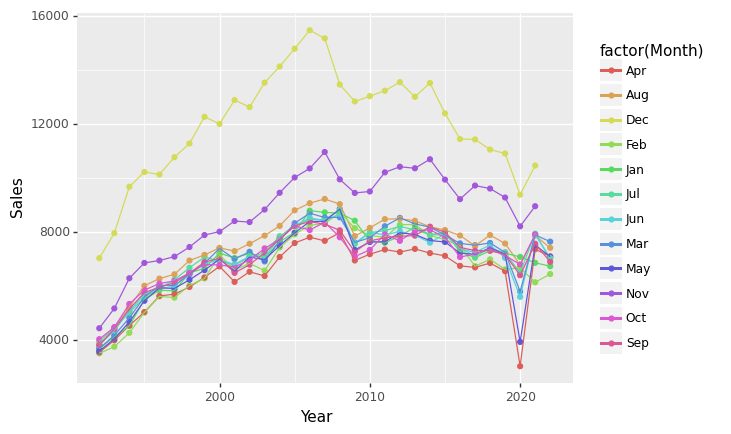

<ggplot: (8789870197233)>

In [ ]:
(
    ggplot(df,aes('Year', 'Sales',color='factor(Month)')) + geom_point() + geom_line()
    )

There is an overall uptrend until the 2008 market crash, upon which a slight downtrend begins. Furthermore, there appears to be seasonality as specifically months Nov. and Dec. saw average sales much higher than those of the other months

In [ ]:
df['DateTime'] = df['Month'].astype(str) + '-' + df['Year'].astype(str)
df['DateTime'] = pd.to_datetime(df['DateTime']).dt.to_period('M')
df

In [ ]:
df['Time'] = list(range(1,df.shape[0]+1))
df['Trend'] = list(range(1,df.shape[0]+1))

In [ ]:
df['COVID'] = 0
df.loc[338:,'COVID'] = 1

In [ ]:
df['SalesBefore'] = df['Sales']
df.loc[df['COVID']==1,'SalesBefore'] = np.nan

REGRESSION MODEL

In [ ]:
M1 = smf.ols('SalesBefore ~ Trend + C(Month)',data = df).fit()
# old = ordinary least squares = linear regression model
print(M1.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.755
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     83.53
Date:                Wed, 26 Oct 2022   Prob (F-statistic):           1.28e-91
Time:                        18:50:32   Log-Likelihood:                -2808.4
No. Observations:                 338   AIC:                             5643.
Df Residuals:                     325   BIC:                             5693.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        4928.3340    210.820     

In [ ]:
df['M1'] = M1.fittedvalues
df['M1resid'] = M1.resid

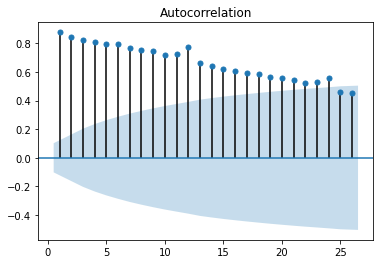

In [ ]:
plot_acf(df['M1resid'],missing='drop',zero=False);

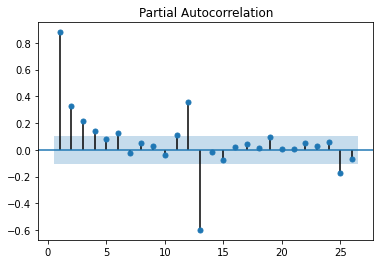

In [ ]:
plot_pacf(df.loc[df['M1resid'].notna(),'M1resid'],zero=False);

In [ ]:
df['SalesBeforeLag1'] = df['SalesBefore'].shift(1)
df['SalesBeforeLag2'] = df['SalesBefore'].shift(2)
df['SalesBeforeLag12'] = df['SalesBefore'].shift(12)
df['SalesBeforeLag13'] = df['SalesBefore'].shift(13)

In [ ]:
M2 = smf.ols('SalesBefore ~ Trend + C(Month) + SalesBeforeLag1 + SalesBeforeLag2 + SalesBeforeLag12 + SalesBeforeLag13',data = df).fit()
# old = ordinary least squares = linear regression model
print(M2.summary())

                            OLS Regression Results                            
Dep. Variable:            SalesBefore   R-squared:                       0.986
Model:                            OLS   Adj. R-squared:                  0.985
Method:                 Least Squares   F-statistic:                     1366.
Date:                Wed, 26 Oct 2022   Prob (F-statistic):          4.37e-275
Time:                        18:50:33   Log-Likelihood:                -2217.4
No. Observations:                 325   AIC:                             4469.
Df Residuals:                     308   BIC:                             4533.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          175.2738     97.614  

In [ ]:
df['M2'] = M2.fittedvalues
df['M2resid'] = M2.resid

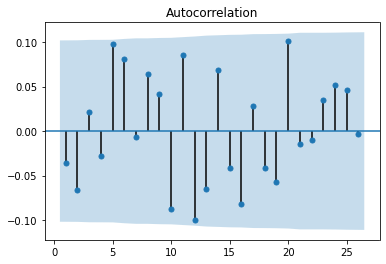

In [ ]:
plot_acf(df['M2resid'],missing='drop',zero=False);

Since less than 5% of observations are statistically significant, this model is appropriate

In [ ]:
df.iloc[[338]]

,Year,Month,Sales,DateTime,Time,Trend,COVID,SalesBefore,M1,M1resid,SalesBeforeLag1,SalesBeforeLag2,SalesBeforeLag12,SalesBeforeLag13,M2,M2resid
338,2020,Mar,5778.0,2020-03,339,339,1,NaN,NaN,NaN,6659.0,7063.0,7229.0,6599.0,NaN,NaN


In [ ]:
df.loc[338,'SalesBefore'] = M2.predict(df.iloc[[338]]).iloc[0]
df.loc[338,'M2'] = M2.predict(df.iloc[[338]]).iloc[0]
df

In [ ]:
df.loc[339,'SalesBeforeLag1'] = df.loc[339-1,'SalesBefore']
df.loc[339,'SalesBeforeLag2'] = df.loc[339-2,'SalesBefore']
df.loc[339,'SalesBeforeLag12'] = df.loc[339-12,'SalesBefore']
df.loc[339,'SalesBeforeLag13'] = df.loc[339-13,'SalesBefore']
df.loc[339,'SalesBefore'] = M2.predict(df.iloc[[339]]).iloc[0]
df.loc[339,'M2'] = M2.predict(df.iloc[[339]]).iloc[0]

In [ ]:
h = df['SalesBefore'].isna().sum()
for i in list(range(len(df) - h, len(df))):
    df.loc[i,'SalesBeforeLag1'] = df.loc[i-1,'SalesBefore']
    df.loc[i,'SalesBeforeLag2'] = df.loc[i-2,'SalesBefore']
    df.loc[i,'SalesBeforeLag12'] = df.loc[i-12,'SalesBefore']
    df.loc[i,'SalesBeforeLag13'] = df.loc[i-13,'SalesBefore']
    df.loc[i,'SalesBefore'] = M2.predict(df.iloc[[i]]).iloc[0]
    df.loc[i,'M2'] = M2.predict(df.iloc[[i]]).iloc[0]

SMOOTHING MODEL

In [ ]:
df['M'] = np.nan

In [ ]:
len(df)

369

In [ ]:
M = ExponentialSmoothing(df.loc[:(len(df) -31 - 1),'Sales'],trend = 'add',seasonal='mul',seasonal_periods=12).fit()

In [ ]:
df.loc[:(len(df) -31 -1),'M'] = M.fittedvalues

In [ ]:
df.loc[(len(df) -31 ):,'M'] = M.forecast(31)

In [ ]:
df['Prediction'] = 'Fitted values'
df.loc[(len(df) -31 ):,'Prediction'] = 'Forecast'

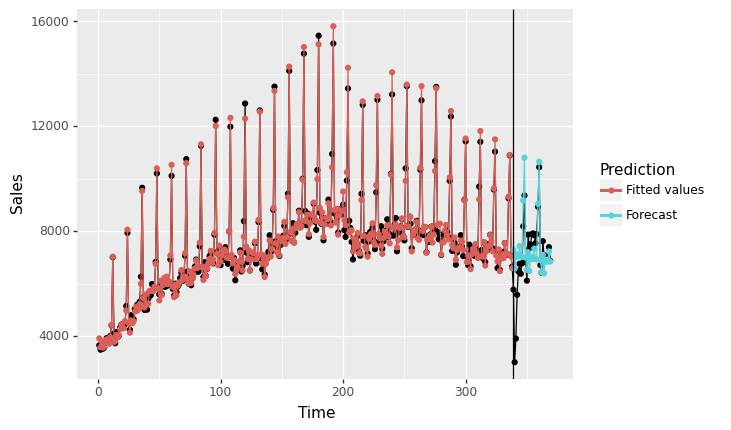

<ggplot: (8789870103901)>

In [ ]:
# Crate a a graph of data and overlay fitted values, and future forecats. 
(
    ggplot(df,aes('Time','Sales')) + geom_point() + geom_line()+
 geom_point(aes('Time','M',color='Prediction')) + geom_line(aes('Time','M',color='Prediction')) +
 geom_vline(xintercept = len(df)- 30)
)

In [ ]:
def rmse(actual,predicted):
    return round(((actual - predicted)**2).mean()**0.5,2)

In [ ]:
def mape(actual,predicted):
    return round(abs((actual - predicted)/actual).mean()*100,2)

In [ ]:
def accuracy(actual,predicted,h=0):
    n_train = len(actual) - h
    accuracy_metrics = pd.DataFrame(columns=['RMSE','MAPE(%)'],index=['Training set','Testing set'])
    accuracy_metrics.loc['Training set','RMSE'] = rmse(actual[:n_train],predicted[:n_train])
    accuracy_metrics.loc['Training set','MAPE(%)'] = mape(actual[:n_train],predicted[:n_train])
    if (h>0):
        accuracy_metrics.loc['Testing set','RMSE'] = rmse(actual[n_train:],predicted[n_train:])
        accuracy_metrics.loc['Testing set','MAPE(%)'] = mape(actual[n_train:],predicted[n_train:])
    return accuracy_metrics

Scenario #1 Regression
Training: 01/92-12/16
Testing: 01/17-12/17

In [ ]:
df.tail(120)

In [ ]:
accuracy(actual = df.loc[1:299,'Sales'], predicted = df.loc[1:299,'M2'],h=12)

,RMSE,MAPE(%)
Training set,222.4,2.05
Testing set,216.38,2.15


Scenario #2 Regression
Training: 01/92-12/17
Testing: 01/18-12/18

In [ ]:
accuracy(actual = df.loc[1:311,'Sales'], predicted = df.loc[1:311,'M2'],h=12)

,RMSE,MAPE(%)
Training set,222.15,2.06
Testing set,309.39,3.31


Scenario #3 Regression
Training: 01/92-12/18
Testing: 01/19-12/19

In [ ]:
accuracy(actual = df.loc[1:323,'Sales'], predicted = df.loc[1:323,'M2'],h=12)

,RMSE,MAPE(%)
Training set,226.3,2.11
Testing set,198.98,1.93


Scenario #1 Smoothing
Training: 01/92-12/16
Testing: 01/17-12/17

In [ ]:
accuracy(actual = df.loc[1:299,'Sales'], predicted = df.loc[1:299,'M'],h=12)

,RMSE,MAPE(%)
Training set,212.99,2.02
Testing set,156.72,1.79


Scenario #2 Smoothing
Training: 01/92-12/17
Testing: 01/18-12/18

In [ ]:
accuracy(actual = df.loc[1:311,'Sales'], predicted = df.loc[1:311,'M'],h=12)

,RMSE,MAPE(%)
Training set,211.02,2.01
Testing set,272.69,2.85


Scenario #3 Smoothing
Training: 01/92-12/18
Testing: 01/19-12/19

In [ ]:
accuracy(actual = df.loc[1:323,'Sales'], predicted = df.loc[1:323,'M'],h=12)

,RMSE,MAPE(%)
Training set,213.73,2.05
Testing set,194.5,1.75


In [ ]:
# AVERAGE TESTING SET MAPE FOR REGRESSION MODEL
(1.79+2.85+1.75)/3

2.1300000000000003

In [ ]:
# AVERAGE TESTING SET MAPE FOR SMOOTHING MODEL
(2.15+3.31+1.93)/3

2.4633333333333334

Since our regression model has generated a lower average MAPE, we will proceed with the rest of the case using such

In [ ]:
# impact of recession = actual demand(March 2020-Present) - predicted demand assuming recession has not happened(March 2020-Present)
Impact = round((df.loc[338:,'Sales'].sum() - df.loc[338:,'M2'].sum()),0)
Impact

-10436.0

COVID caused a total decrease in sales of $10.436B from March 2020-Sep 2022

In [ ]:
ImpactP = Impact/df.loc[338:,'M2'].sum()*100
ImpactP

-4.535693109785212

COVID caused a total percentage decrease in sales of -4.54% from March 2020-Sep 2022

In [ ]:
df_future = df.loc[len(df)-12:,].reset_index(drop=True)
df_future['Sales'] = np.nan
df_future['Year'] = df_future['Year'] + 1

df_future

In [ ]:
df_future['DateTime'] = df_future['Month'].astype(str) + '-' + df_future['Year'].astype(str)
df_future['DateTime'] = pd.to_datetime(df_future['DateTime']).dt.to_period('M')
df_future

In [ ]:
df = pd.concat([df,df_future],axis=0).reset_index(drop=True)


In [ ]:
df['SalesPrediction'] = df['SalesBefore']
df.loc[df['COVID']>0,'SalesBefore'] = np.nan
df.loc[:368,'SalesPrediction'] = np.nan
df

The predicted 12 months of future sales are shown in the dataframe above in column 'SalesPrediction'

In [ ]:
df.tail(12)

In [ ]:
df.loc[369:,'Time'] = df.loc[369:,'Time'] + 12
df.loc[369:,'Trend'] = df.loc[369:,'Trend'] + 12
df.tail(12)

In [ ]:
(
    ggplot(df,aes('Time','Sales')) + geom_point() + geom_line() +
 geom_point(aes('Time','M2'),color='red') + geom_line(aes('Time','M2'),color='red') + theme(figure_size = (12,8)) +
 geom_point(aes('Time','SalesPrediction'),color='blue') + geom_line(aes('Time','SalesPrediction'),color='blue')
)

I believe that my modeling approach does present an accurate picture of current and future data patterns

In [ ]:
# EXTRA CREDIT Q4 - BACKGAMMON
# PROBABILITY OF LOSS = 32/36 = 88.89%
# MINIMUM ACCEPTABLE OFFER: PROB OF LOSS X WAGER AMOUNT
# MINIMUM ACCEPTABLE OFFER: 0.8889*$100
# MINIMUM ACCEPTABLE OFFER: $88.89